# PhageHostLearn - v2.2 (Klebsiella)

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

**Architecture of this framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Hyperdimensional vector embeddings for both that are bound to signatures
- Signatures that are aggregated per label to create profiles
- Unbinding with new loci HDVs on the positive profile to get a proxy for the closest multiRBP HDV
- Cosine similarity to compute and rank the closest known multiRBP embeddings

**Overview of the notebook**:

1. [Defining the necessary functions](#functions)
2. [Transform the loci sequences into embeddings](#lociembed) using hyperdimensional vectors
3. [Transform the RBP sequences into embeddings](#rbpembed) using hyperdimensional vectors
4. [Compute joint features: bind or concat](#joint)
5. [Aggregation and cosine similarity](#hdc)

## 0 - Libraries and directories

In [1]:
using CSV
using MLJ
using Test
using JSON
using Plots
using FASTX
using MLBase
using Colors
using Random
using XGBoost
using StatsBase
using Statistics
using DataFrames
using ScikitLearn
using BioAlignments
using ProgressMeter
using LinearAlgebra
using ProgressMeter
using BioAlignments
using DelimitedFiles
using MultivariateStats
using ScikitLearn.Pipelines: Pipeline
using ScikitLearn.CrossValidation: train_test_split 
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn.Skcore: make_scorer

@sk_import decomposition: PCA
@sk_import ensemble: RandomForestClassifier
@sk_import metrics: roc_auc_score

push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing

general_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data" # general directory
results_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models"
data_suffix = "Valencia"; # choose a suffix for the created data files

## 1 - Functions<a name="functions"></a>

In [2]:
function file_to_array(file)
    """
    Function that reads a FASTA file and puts its sequences in an array.
    """
    sequences = []
    reader = FASTA.Reader(open(file, "r"))
    for record in reader
        seq = FASTA.sequence(record)
        push!(sequences, seq)
    end
    return sequences
end

file_to_array (generic function with 1 method)

In [3]:
function mean_reciprocal_rank(queries)
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    if isa(queries, Matrix)
        queries_list = [queries[i,:] for i in 1:size(queries)[1]]
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries_list]
    else
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries]
    end
    return mean(reciprocal_ranks)
end

mean_reciprocal_rank (generic function with 1 method)

In [4]:
function sort_label_matrix(score_matrix, label_matrix)
    """
    This function sorts the label matrix based on the score matrix.
    It does so per row (corresponding to bacteria in our setting).
    
    WARNING: The sortperm function will rank equal elements by ascending index order. 
    This potentially can cause an underestimation of performance (MRR), as it can be that 
    an irrelevant 0 appears earlier and then is place before a relevant 1.
    """
    @assert size(label_matrix) == size(score_matrix)
    sorted_matrix = zeros(Int64, size(label_matrix)[1], size(label_matrix)[2])
    for i in 1:size(label_matrix)[1] # loop over rows
        label_row = label_matrix[i,:]
        score_row = score_matrix[i,:]
        sorted_row = label_row[sortperm(score_row, rev=true)]
        sorted_matrix[i,:] = sorted_row
    end
    return sorted_matrix
end

sort_label_matrix (generic function with 1 method)

In [5]:
function mrr_from_scores(score_matrix, label_matrix)
    """
    This function is a wrapper for the previous functions that computes
    the MRR starting from a matrix of (prediction) scores, a threshold above
    which to consider an interaction positive and a label matrix.
    """
    # sort the matrix per row and compute
    replace!(label_matrix, missing => 0)
    sorted_matrix = sort_label_matrix(score_matrix, label_matrix)
    
    return mean_reciprocal_rank(sorted_matrix)
end

mrr_from_scores (generic function with 1 method)

In [6]:
function auc_from_scores(scores_flat, labels_flat)
    """
    This function computes the AUC from raw scores returned by ScikitLearn classifiers.
    For the AUC, we need the flat versions of scores and labels that don't contain missing 
    values (if not, this will skew the results).
    
    Dependencies: MLJ
    """
    c = ["neg", "pos"]
    labels_cat = categorical(c[labels_flat .+ 1])
    scores_uni = [UnivariateFinite(categorical(["neg", "pos"]), [1.0 - p, p]) for p in scores_flat]
    AUC = auc(scores_uni, labels_cat)
    return AUC
end

auc_from_scores (generic function with 1 method)

In [7]:
function compute_performance(score_matrix, label_matrix, scores_flat, labels_flat)
    """
    Wrapper function that computes the two relevant results we want to compare for 
    our models: the ROC AUC and the MRR.    
    """
    MRR = mrr_from_scores(score_matrix, label_matrix) # compute MRR
    AUC = auc_from_scores(scores_flat, labels_flat) # compute AUC
    return MRR, AUC
end

compute_performance (generic function with 1 method)

## 2 - Computing loci embeddings<a name="lociembed"></a>

In this section, we define hyperdimensional vectors for the amino-acid alphabet and use these hyperdimensional vectors to construct *hyperdimensional embeddings* for our loci proteins. For the loci proteins, this is a multi-instance setting: multiple proteins will be embedded into hyperdimensional space and then those vectors are aggregated to form one final vector for each locus.

In [8]:
# load data
LociBase = JSON.parsefile(general_dir*"/Locibase"*data_suffix*".json");

In [9]:
# define protein alphabet
alphabet = "GAVLIFPSTYCMKRHWDENQX"
basis = Dict(c=>BipolarHDV() for c in alphabet);

In [10]:
# compute loci embeddings w/ proteins (multi-instance)
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 6) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

## 3 - Computing RBP embeddings<a name="rbpembed"></a>

We combine the vectors for each phage's RBP(s), also a multi-instance setting

In [11]:
# load data
RBPbase = DataFrame(CSV.File(general_dir*"/RBPbase"*data_suffix*".csv"));

In [12]:
# compute rbp embeddings
rbp_embeddings = Array{BipolarHDV}(undef, length(unique(RBPbase.phage_ID)))
for (i, phageid) in enumerate(unique(RBPbase.phage_ID))
    subset = filter(row -> row.phage_ID == phageid, RBPbase)
    protein_hdvs = [sequence_embedding(string(sequence), basis, 6) for sequence in subset.protein_sequence]
    multirbp_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    rbp_embeddings[i] = multirbp_hdv
end

## 4 - Compute joint signatures by binding<a name="joint"></a>

In [13]:
IM = DataFrame(CSV.File(general_dir*"/phage_host_interactions"*data_suffix*".csv"))
rename!(IM,:Column1 => :Host)
interaction_matrix = Matrix(IM[1:end, 2:end])
#loci_names = IM.accession
#serotypes = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"))
#rbp_names = names(IM)[2:end];

In [14]:
# compute sigatures for loci x RBP embeddings
features_bind = []
labels = []
loci_groups = []
rbp_groups = []
for (i, accession) in enumerate(collect(keys(LociBase)))
    for (j, phage_id) in enumerate(unique(RBPbase.phage_ID))
        subset = filter(row -> row.Host == accession, IM)
        interaction = subset[!, phage_id][1]
        if isequal(interaction, 1) || isequal(interaction, 0)
            signature = HyperdimensionalComputing.bind([loci_embeddings[i], rbp_embeddings[j]])
            push!(features_bind, signature)
            push!(labels, trunc(Int, interaction))
            push!(loci_groups, i)
            push!(rbp_groups, j)
        end
    end
end

In [15]:
# put the signatures in a matrix for sklearn
features_b = zeros(Int64, length(features_bind), 10000)
for i in range(1, length=length(features_bind))
    features_b[i,:] = features_bind[i]
end

## 6 - HDC learning<a name="hdc"></a>

##### Simple test

Take a random set of loci apart for testing, use the remaining signatures to train a positive profile, then loop over the test loci and unbind from the positive profile, for each unbind, loop over every known multiRBP embedding and compute cosine similarity to rank the multiRBP embeddings for each of the test loci.

Remark: perhaps this only works with binary vectors, because * and XOR are inverse of one another (Kanerva), but not sure if that is the same for bipolar vectors.

In [35]:
shuffled_groups = shuffle(unique(loci_groups))
train_groups = shuffled_groups[11:end]
test_groups = shuffled_groups[1:10];
x_train = [features_bind[i] for i in 1:size(features_bind)[1] if loci_groups[i] in train_groups]
y_train = [labels[i] for i in 1:size(features_bind)[1] if loci_groups[i] in train_groups]
positives = convert(Array{BipolarHDV}, x_train[y_train .== 1])
pos_aggregate = HyperdimensionalComputing.aggregate(positives)

auc_scores = []
ranked_q = []
for i in test_groups
    locus_hdv = loci_embeddings[i]
    unbind = HyperdimensionalComputing.bind([locus_hdv, pos_aggregate])
    y_test = labels[loci_groups .== i] # get corresponding labels for this locus test group
    if sum(y_test) > 0
        x_test_index = rbp_groups[loci_groups .== i] # get corresponding rbp indices for this test group
        scores = [(cos_sim(rbp_embeddings[j], unbind)+1)/2 for j in x_test_index]
        this_auc = roc_auc_score(y_test, scores)
        push!(auc_scores, this_auc)
        sorted_query = y_test[sortperm(scores, rev=true)] # sort labels to compute MRR later
        push!(ranked_q, sorted_query)
    else
        println("unable to compute AUC/MRR for this group: ", i)
    end
end

unable to compute AUC/MRR for this group: 54
unable to compute AUC/MRR for this group: 198
unable to compute AUC/MRR for this group: 83
unable to compute AUC/MRR for this group: 59


In [36]:
mean(auc_scores)

0.8123575498575498

##### Binding

In [41]:
# perform K-fold cross-validation and keep the scores
scores_pos = []
kfold_labels = []
for (train_indices, test_indices) in CrossValidation.StratifiedKFold(labels, n_folds=5, shuffle=true, random_state=42)
    # define training and test data
    x_train = features_bind[train_indices]
    y_train = labels[train_indices]
    loci_test = loci_groups[test_indices]
    rbps_test = rbp_groups[test_indices]
    y_test = labels[test_indices]
    
    # train pos aggregate
    positives = convert(Array{BipolarHDV}, x_train[y_train .== 1])
    pos_aggregate = HyperdimensionalComputing.aggregate(positives)
    
    # compute similarities
    for (i, loci_index) in enumerate(loci_test)
        test_locus = loci_embeddings[loci_index]
        test_rbp = rbp_embeddings[rbps_test[i]]
        unbind = HyperdimensionalComputing.bind([test_locus, pos_aggregate])
        push!(scores_pos, (cos_sim(test_rbp, unbind)+1)/2)
        push!(kfold_labels, y_test[i])
    end
end

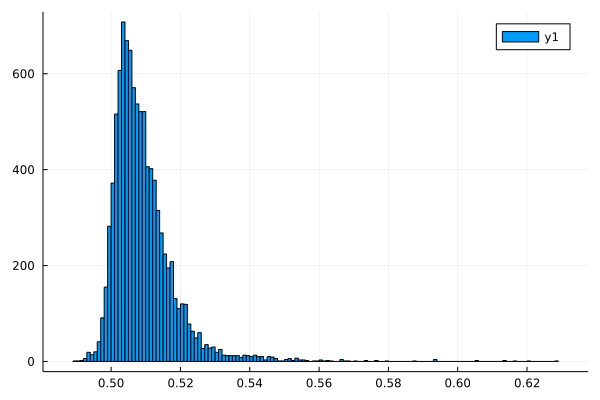

In [46]:
histogram(scores_pos)

In [42]:
roc_auc_score(kfold_labels, scores_pos)

0.737620745392801

In [43]:
# save scores for plotting
results = DataFrame(labels=kfold_labels, scores=scores_pos)
CSV.write(results_dir*"/v2.2/hdc_structured_scores.csv", results)

"/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models/v2.2/hdc_structured_scores.csv"

We see quite a good AUC score for the scores_pos (only comparing to the positive aggregate), however all the scores are very close to 0.5 (which unscaled would be a cossim = 0) -> but isn't that logical as we are binding in high-dimensional spaces? As you bind, you make something that is almost independent to any other thing in the space, so makes sense that all cosinesims are around 0.5?

## X - Tests

In [69]:
@testset "tests for MRR" begin
    @test mean_reciprocal_rank([[0, 0, 0], [0, 1, 0], [1, 0, 0]]) == 0.5
    @test mean_reciprocal_rank([[1, 0, 0], [1, 1, 0], [1, 0, 0]]) == 1
    A = [0 0 0; 0 1 0; 1 0 0] # Matrix
    @test mean_reciprocal_rank(A) == 0.5
end;

Test Summary: | Pass  Total
tests for MRR |    3      3


In [51]:
@testset "tests for constructing relevant matrix" begin
    preds = [0 0 1; 1 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == labels # all TPs
    preds = [0 0 0; 1 0 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 0 0; 0 0 0] # missed TPs
    preds = [0 1 0; 1 1 0; 1 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 1 0; 0 0 0] # FPs
end;

Test Summary:                          | Pass  Total
tests for constructing relevant matrix |    3      3


In [122]:
@testset "tests for sorting label matrix" begin 
    rel = [0 0 1; 1 1 0; 0 0 0]
    scores = [0.5 0.3 1; 1 0.3 0.7; 0.2 0.3 0.3]
    @test sort_label_matrix(scores, rel) == [1 0 0; 1 0 1; 0 0 0]
    
    rel = [0 0 1; 1 1 0; 0 0 0]
    scores = [1 0.3 1; 1 0.3 0.7; 0.2 0.3 0.3] # equal score for 0 and 1
    @test sort_label_matrix(scores, rel) == [0 1 0; 1 0 1; 0 0 0] # equals will appear in ascending order
end;

Test Summary:                  | Pass  Total
tests for sorting label matrix |    2      2


In [124]:
@testset "tests pipeline" begin
    preds = [0 0 1; 0 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    scores = [0 0.2 0.5; 0.3 0.2 0.1; 0.2 0.4 0.3]
    relm = construct_relevant_matrix(preds, labels)
    sortm = sort_label_matrix(scores, relm)
    @test construct_relevant_matrix(preds, labels) == [0 0 1; 0 1 0; 0 0 0]
    @test sort_relevant_matrix(relm, scores) == [1 0 0; 0 1 0; 0 0 0] 
    @test mean_reciprocal_rank(sortm) == 0.5
end;

Test Summary:  | Pass  Total
tests pipeline |    3      3


In [28]:
@testset "tests mrr from scores" begin
    labels = [0 0 1; 1 1 0; 0 0 0]
    scores = [0 0.2 0.5; 0.3 0.5 0.6; 0.2 0.4 0.3]
    @test mrr_from_scores(scores, labels, 0.4) == 0.5
end;

Test Summary:         | Pass  Total
tests mrr from scores |    1      1


## X - Legacy code